### Loading in dependencies and defining machine learning function to automate the process of running models and obtaining performance metrics.

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_fscore_support,classification_report,confusion_matrix,ConfusionMatrixDisplay, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
import pickle5 as pickle
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns


def machine_learn(algorithm, X_train, X_test, y_train, y_test, algo_name="unknown"):
    
    
    
    #Fitting and predicting starts here
    algorithm.fit(X_train, y_train)
    preds = algorithm.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, algorithm.predict_proba(X_test)[:,1])
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    preds_best_cutoff = pd.Series(preds).apply(lambda x: 1 if x > best_thresh else 0)
    preds_best_cutoff = preds_best_cutoff.tolist()
    a_score = accuracy_score(y_test, preds_best_cutoff)
    auc_value = roc_auc_score(y_test, preds_best_cutoff)
    print(classification_report(y_test,preds_best_cutoff))
    print("It has accuracy of {} AUC of {}".format(a_score,auc_value))
    
    
    #confusion matrix
    cm = confusion_matrix(y_test, preds_best_cutoff, labels=[0,1])
    print(cm)
    return fpr, tpr, auc_value
   
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X.columns)), 
                               columns=['Value','Feature'])
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    print(feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-{}.png'.format(num))

### Loading in and cleaning data set: The data set contains all of the NBA draft combine measurements for all players from 2000 to 2019 as well as their four-year-average Box Plus Minus (BPM). We would like to predict if a player's four-year-average BPM is >= 0 or <0. A BPM >= to 0 indicate the player is at least a sixth men, and a BPM <0 indicate a bench player. This problem is treated as a binary classification problem.

In [3]:
four_years_df = pd.read_pickle("cleaned_df.pkl")
four_years_df = four_years_df[four_years_df['MP']>250]
four_years_df = four_years_df.drop(['POS','Name','YEAR','Season','through_4_years','WITH SHOES','MP'],axis=1)
four_years_df = pd.get_dummies(four_years_df)
# Setting Avg_BPM >=0 as 1, and < 0 as 0
four_years_df['Avg_BPM'] = (four_years_df['Avg_BPM'] >= 0).astype(int)
#setting first year BPM >=0 as 1, and < 0 as 0.
four_years_df['BPM'] = (four_years_df['BPM'] >= 0).astype(int)

###  Train-test split four - year average

In [5]:
train, test = train_test_split(four_years_df, test_size=0.2, random_state=42, stratify=four_years_df['Avg_BPM'])
train, validate = train_test_split(train, test_size=0.10, random_state=42, stratify=train['Avg_BPM'])
print("Upsampling training...")  
ros = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = ros.fit_resample(train.drop(['BPM','Avg_BPM'],axis=1), train['Avg_BPM'])
X_test = test.copy(deep=True).drop(['BPM','Avg_BPM'], axis=1)
y_test = test['Avg_BPM']
X_valid = validate.copy(deep=True).drop(['BPM','Avg_BPM'], axis=1)
y_valid = validate['Avg_BPM']
assert X_test.shape[0] == y_test.shape[0], "wrong shapes for test set"
assert X_train.shape[0] == y_train.shape[0], "wrong shapes for training set"
assert X_valid.shape[0] == y_valid.shape[0], "wrong shapes for training set"


Upsampling training...


#### This part standarizes certain continues varaibles. This is important for algorithims like KNN and MLP.

### Predicting four year average

              precision    recall  f1-score   support

           0       0.86      0.48      0.62       131
           1       0.24      0.69      0.36        32

    accuracy                           0.52       163
   macro avg       0.55      0.58      0.49       163
weighted avg       0.74      0.52      0.57       163

It has accuracy of 0.5214723926380368 AUC of 0.5842080152671756
[[63 68]
 [10 22]]
Done with NB
              precision    recall  f1-score   support

           0       0.81      0.97      0.89       131
           1       0.43      0.09      0.15        32

    accuracy                           0.80       163
   macro avg       0.62      0.53      0.52       163
weighted avg       0.74      0.80      0.74       163

It has accuracy of 0.7975460122699386 AUC of 0.5316078244274809
[[127   4]
 [ 29   3]]
Done with rf
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       131
           1       0.27      0.28      0.

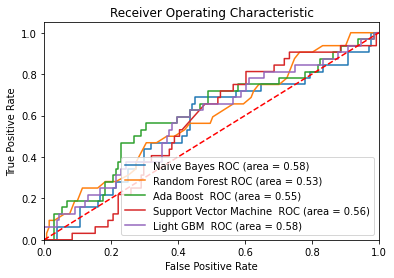

In [82]:
plt.figure()

bayes = GaussianNB()
fpr, tpr, auc = machine_learn(bayes, X_train, X_test, y_train, y_test, "NaiveBayes")
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("Naive Bayes", auc))
print("Done with NB")

rf = RandomForestClassifier()
fpr, tpr, auc = machine_learn(rf, X_train, X_test, y_train, y_test, "RandomForest")
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("Random Forest", auc))
print("Done with rf")

adBoost = AdaBoostClassifier()
fpr, tpr, auc = machine_learn(adBoost, X_train, X_test, y_train, y_test, "AdaBoost")      
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("Ada Boost ", auc))
print("Done with adBoost")

svc =SVC(probability=True)
fpr, tpr, auc = machine_learn(svc, X_train, X_test, y_train, y_test, "SVC")      
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("Support Vector Machine ", auc))

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'l1', "binary"},
  #  'metric': None,
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 50,
    'verbose': -1
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
             # feval=lgb_precision,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)




print('Starting predicting...')
# predict
preds_proba = gbm.predict(X_test, num_iteration=gbm.best_iteration) 
fpr, tpr, thresholds = metrics.roc_curve(y_test,preds_proba)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
preds_best_cutoff = pd.Series(preds_proba).apply(lambda x: 1 if x > best_thresh else 0)
preds_best_cutoff = preds_best_cutoff.tolist()
a_score = accuracy_score(y_test, preds_best_cutoff)
auc_value = roc_auc_score(y_test, preds_best_cutoff)
print(classification_report(y_test,preds_best_cutoff))
print("It has accuracy of {} AUC of {}".format(a_score,auc_value))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("Light GBM ", auc_value))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


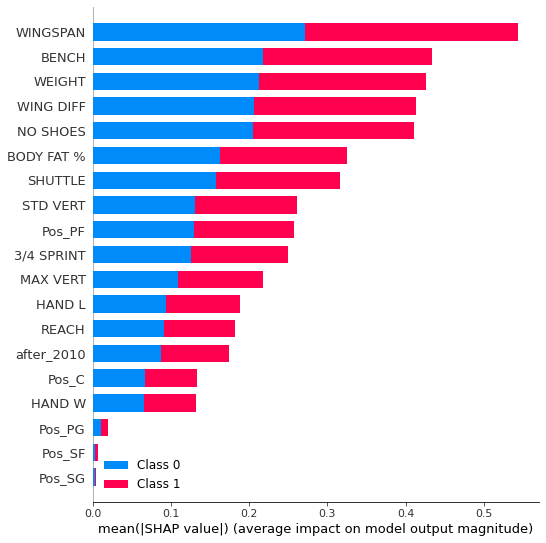

In [83]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

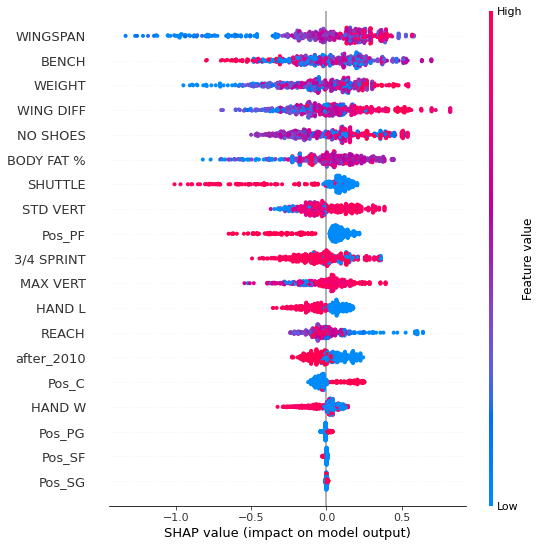

In [84]:
shap.summary_plot(shap_values[1], X_train)

###  Train-test split first year BPM

In [85]:
train, test = train_test_split(four_years_df, test_size=0.3, random_state=42, stratify=four_years_df['BPM'])

print("Upsampling training...")  
ros = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = ros.fit_resample(train.drop(['BPM','Avg_BPM'],axis=1), train['BPM'])
X_test = test.copy(deep=True).drop(['BPM','Avg_BPM'], axis=1)
y_test = test['BPM']
assert X_test.shape[0] == y_test.shape[0], "wrong shapes for test set"
assert X_train.shape[0] == y_train.shape[0], "wrong shapes for training set"

Upsampling training...


### Predicting first-year BPM

              precision    recall  f1-score   support

           0       0.89      0.51      0.65       143
           1       0.14      0.55      0.22        20

    accuracy                           0.52       163
   macro avg       0.51      0.53      0.43       163
weighted avg       0.80      0.52      0.60       163

It has accuracy of 0.5153374233128835 AUC of 0.5302447552447552
[[73 70]
 [ 9 11]]
Done with NB
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       143
           1       0.33      0.05      0.09        20

    accuracy                           0.87       163
   macro avg       0.61      0.52      0.51       163
weighted avg       0.81      0.87      0.83       163

It has accuracy of 0.8711656441717791 AUC of 0.518006993006993
[[141   2]
 [ 19   1]]
Done with rf
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       143
           1       0.12      0.20      0.1

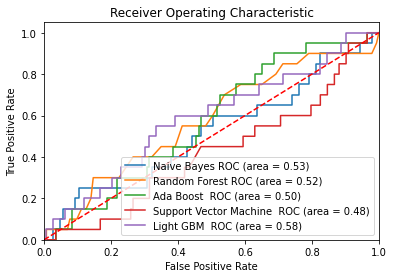

In [86]:
plt.figure()

bayes = GaussianNB()
fpr, tpr, auc = machine_learn(bayes, X_train, X_test, y_train, y_test, "NaiveBayes")
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("Naive Bayes", auc))
print("Done with NB")

rf = RandomForestClassifier()
fpr, tpr, auc = machine_learn(rf, X_train, X_test, y_train, y_test, "RandomForest")
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("Random Forest", auc))
print("Done with rf")

adBoost = AdaBoostClassifier()
fpr, tpr, auc = machine_learn(adBoost, X_train, X_test, y_train, y_test, "AdaBoost")      
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("Ada Boost ", auc))
print("Done with adBoost")

svc =SVC(probability=True)
fpr, tpr, auc = machine_learn(svc, X_train, X_test, y_train, y_test, "SVC")      
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("Support Vector Machine ", auc))

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'l1', "binary"},
  #  'metric': None,
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 50,
    'verbose': -1
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
             # feval=lgb_precision,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)




print('Starting predicting...')
# predict
preds_proba = gbm.predict(X_test, num_iteration=gbm.best_iteration) 
fpr, tpr, thresholds = metrics.roc_curve(y_test,preds_proba)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
preds_best_cutoff = pd.Series(preds_proba).apply(lambda x: 1 if x > best_thresh else 0)
c = preds_best_cutoff.tolist()
a_score = accuracy_score(y_test, preds_best_cutoff)
auc_value = roc_auc_score(y_test, preds_best_cutoff)
print(classification_report(y_test,preds_best_cutoff))
print("It has accuracy of {} AUC of {}".format(a_score,auc_value))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ("Light GBM ", auc_value))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

    Value     Feature
18    171      WEIGHT
17    162  BODY FAT %
16    155   WING DIFF
15    144  3/4 SPRINT
14    117    WINGSPAN
13    110       BENCH
12    101       REACH
11     99    STD VERT
10     93    NO SHOES
9      77    MAX VERT
8      54      HAND L
7      51     SHUTTLE
6      40      HAND W
5      33  after_2010
4      20      Pos_SF
3      19       Pos_C
2      17      Pos_SG
1       9      Pos_PF
0       0      Pos_PG


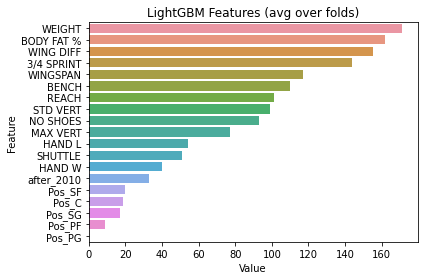

In [87]:
plotImp(gbm, X_train, num=20)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


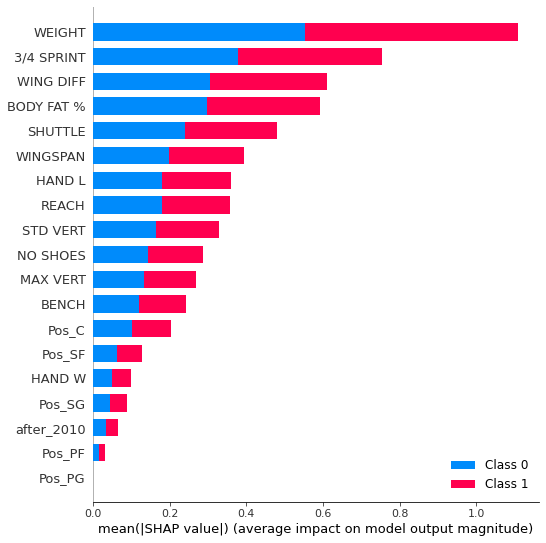

In [88]:
import shap
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## Each SHAP value expresses, this is the important part here, the marginal effect that the observed level of a variable for an individual has on the final predicted probability for that individual.

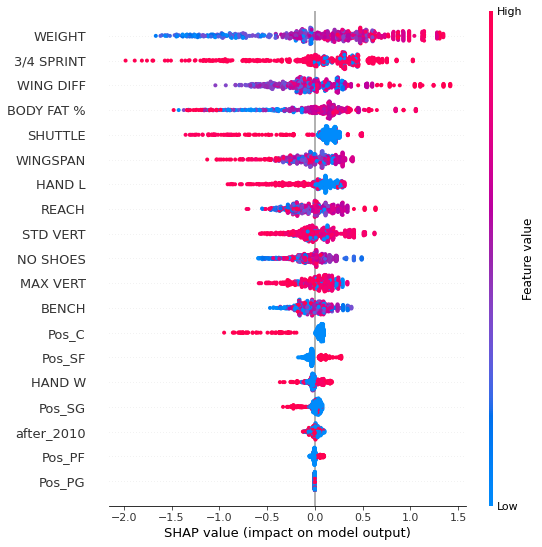

In [89]:
shap.summary_plot(shap_values[1], X_train)

### Loading in 2020 draft as time hold-out-test set

In [71]:
test_2021 = pd.read_pickle("2021_test.pkl")
test_2021 = test_2021[test_2021['MP']>250]
test_2021 = test_2021.drop(['Name','Season','through_4_years','MP'],axis=1)
test_2021 = pd.get_dummies(test_2021)
# Setting Avg_BPM >=0 as 1, and < 0 as 0
test_2021['Avg_BPM'] = (test_2021['Avg_BPM'] >= 0).astype(int)
#setting first year BPM >=0 as 1, and < 0 as 0.
test_2021['BPM'] = (test_2021['BPM'] >= 0).astype(int)

In [74]:
print("Upsampling training...")  
ros = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = ros.fit_resample(four_years_df.drop(['BPM','Avg_BPM'],axis=1), four_years_df['BPM'])
X_test = test_2021.copy(deep=True).drop(['BPM','Avg_BPM'], axis=1)
y_test = test_2021['BPM']

Upsampling training...


In [75]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'l1', "binary"},
  #  'metric': None,
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 50,
    'verbose': -1
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
             # feval=lgb_precision,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)




print('Starting predicting...')
# predict
preds_proba = gbm.predict(X_test, num_iteration=gbm.best_iteration) 
fpr, tpr, thresholds = metrics.roc_curve(y_test,preds_proba)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
preds_best_cutoff = pd.Series(preds_proba).apply(lambda x: 1 if x > best_thresh else 0)
preds_best_cutoff = preds_best_cutoff.tolist()
a_score = accuracy_score(y_test, preds_best_cutoff)
auc_value = roc_auc_score(y_test, preds_best_cutoff)
print(classification_report(y_test,preds_best_cutoff))
print("It has accuracy of {} AUC of {}".format(a_score,auc_value))

Starting training...
[1]	valid_0's l1: 0.491495	valid_0's binary_logloss: 0.676931	valid_0's l2: 0.241898
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.488966	valid_0's binary_logloss: 0.671937	valid_0's l2: 0.239414
[3]	valid_0's l1: 0.47019	valid_0's binary_logloss: 0.636571	valid_0's l2: 0.221801
[4]	valid_0's l1: 0.467972	valid_0's binary_logloss: 0.632684	valid_0's l2: 0.219923
[5]	valid_0's l1: 0.450464	valid_0's binary_logloss: 0.601326	valid_0's l2: 0.204444
[6]	valid_0's l1: 0.454024	valid_0's binary_logloss: 0.607752	valid_0's l2: 0.207697
[7]	valid_0's l1: 0.459297	valid_0's binary_logloss: 0.618277	valid_0's l2: 0.213057
[8]	valid_0's l1: 0.460782	valid_0's binary_logloss: 0.621618	valid_0's l2: 0.214795
[9]	valid_0's l1: 0.464292	valid_0's binary_logloss: 0.63014	valid_0's l2: 0.219268
[10]	valid_0's l1: 0.46843	valid_0's binary_logloss: 0.640768	valid_0's l2: 0.224844
Early stopping, best iteration is:
[5]	valid_0's l1: 0.450464	valid_0's